## START

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 85 kB 841 kB/s 
     |████████████████████████████████| 462 kB 53.3 MB/s 
     |████████████████████████████████| 4.2 MB 21.7 MB/s 


In [2]:
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import os
import pandas as pd
import pprint

In [3]:
cd /content/drive/Othercomputers/My Laptop/Bangkit/Capstone/Recommender system

[Errno 2] No such file or directory: '/content/drive/Othercomputers/My Laptop/Bangkit/Capstone/Recommender system'
/content


In [4]:
print(os.getcwd())

/content


## SKIP

In [ ]:
# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

In [ ]:
# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})
movies = movies.map(lambda x: x["movie_title"])

In [ ]:
for i in ratings.take(5).as_numpy_iterator():
  print(i)

{'movie_title': b"One Flew Over the Cuckoo's Nest (1975)", 'user_id': b'138'}
{'movie_title': b'Strictly Ballroom (1992)', 'user_id': b'92'}
{'movie_title': b'Very Brady Sequel, A (1996)', 'user_id': b'301'}
{'movie_title': b'Pulp Fiction (1994)', 'user_id': b'60'}
{'movie_title': b'Scream 2 (1997)', 'user_id': b'197'}


In [ ]:
list(movies.as_numpy_iterator())

In [ ]:
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None, output_mode =  'one_hot')
movie_titles_vocabulary.adapt(movies)

In [ ]:
test_data = tf.constant([['One Flew Over the Cuckoo\'s Nest (1975)'], ['Strictly Ballroom (1992)'], ['Very Brady Sequel, A (1996)']])
encoded_data = movie_titles_vocabulary(test_data)
encoded_data.numpy()[:,576]

array([1., 0., 0.], dtype=float32)

In [ ]:
test_data = tf.constant([['One Flew Over the Cuckoo\'s Nest (1975)'], ['Strictly Ballroom (1992)'], ['Very Brady Sequel, A (1996)']])
encoded_data = movie_titles_vocabulary(test_data)
# encoded_data.numpy()[:,365]
encoded_data

<tf.Tensor: shape=(3, 1), dtype=int64, numpy=
array([[576],
       [263],
       [101]])>

In [ ]:
class MovieLensModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

  def __init__(
      self,
      user_model: tf.keras.Model,
      movie_model: tf.keras.Model,
      task: tfrs.tasks.Retrieval):
    super().__init__()

    # Set up user and movie representations.
    self.user_model = user_model
    self.movie_model = movie_model

    # Set up a retrieval task.
    self.task = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Define how the loss is computed.

    user_embeddings = self.user_model(features["user_id"])
    movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, movie_embeddings)

In [ ]:
# Define user and movie models.
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), 64)
])
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64)
])

# Define your objectives.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
  )
)

In [ ]:
# Create a retrieval model.
model = MovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Train for 3 epochs.
model.fit(ratings.batch(4096), epochs=3)

# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title))))

# Get some recommendations.
_, titles = index(np.array(["42"]))
print(f"Top 3 recommendations for user 42: {titles[0, :3]}")

Epoch 1/3
25/25 [==============================] - 31s 1s/step - factorized_top_k/top_1_categorical_accuracy: 9.0000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0047 - factorized_top_k/top_50_categorical_accuracy: 0.0447 - factorized_top_k/top_100_categorical_accuracy: 0.1012 - loss: 33100.0545 - regularization_loss: 0.0000e+00 - total_loss: 33100.0545
Epoch 2/3
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 2.7000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0051 - factorized_top_k/top_10_categorical_accuracy: 0.0143 - factorized_top_k/top_50_categorical_accuracy: 0.1045 - factorized_top_k/top_100_categorical_accuracy: 0.2110 - loss: 31014.0403 - regularization_loss: 0.0000e+00 - total_loss: 31014.0403
Epoch 3/3
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 5.6000e-04 - factorized_top_k/top_5_categorical_accu

## RUN EXAMPLE

In [ ]:
tourism_rating = pd.read_csv("https://raw.githubusercontent.com/AgungP88/getloc-apps/machine-learning/dataset/tourism_rating.csv")

In [ ]:
tourism_rating.head(10)

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
5,1,312,2
6,1,258,5
7,1,20,4
8,1,154,2
9,1,393,5


In [ ]:
tourism_rating.tail()

,User_Id,Place_Id,Place_Ratings
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4
9999,300,163,2


In [ ]:
tourism_rating.dtypes

User_Id          int64
Place_Id         int64
Place_Ratings    int64
dtype: object

We need a library that can parallelized input streams such as text embedding and tokenization, data normalization, and data sparsity altogether such that they can be processed seamlessly without over-exhausting the computing capacity

In [ ]:
tourism_id = pd.read_csv("https://raw.githubusercontent.com/AgungP88/getloc-apps/machine-learning/dataset/tourism_with_id.csv")

In [ ]:
tourism_id.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [ ]:
tourism_id['Category'].unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah'], dtype=object)

In [ ]:
tourism_id.dtypes

Place_Id          int64
Place_Name       object
Description      object
Category         object
City             object
Price             int64
Rating          float64
Time_Minutes    float64
Coordinate       object
Lat             float64
Long            float64
Unnamed: 11     float64
Unnamed: 12       int64
dtype: object

In [ ]:
tourism_id[tourism_id["Place_Id"] == 1]["Category"]

0    Budaya
Name: Category, dtype: object

In [ ]:
tourism_id.loc[1]["Category"]

'Budaya'

In [ ]:
tourism_rating["Place_Category"] = tourism_rating["Place_Id"].map(lambda x: tourism_id.loc[x-1]["Category"])

In [ ]:
tourism_rating.head()

,User_Id,Place_Id,Place_Ratings,Place_Category
0,1,179,3,Budaya
1,1,344,2,Bahari
2,1,5,5,Taman Hiburan
3,1,373,3,Budaya
4,1,101,4,Budaya


In [ ]:
tourism_rating[["Place_Id","User_Id"]] = tourism_rating[["Place_Id","User_Id"]].astype(str)

In [ ]:
# !tfds new my_dataset

In [ ]:
place = tourism_id[["Place_Id","Place_Name","Category"]]
place.to_csv(os.path.join('/content/drive/Othercomputers/My Laptop/Bangkit/Capstone/Recommender system/my_dataset','place.csv'), header=False,index=False)

In [ ]:
rating = tourism_rating[['User_Id','Place_Id']].astype(str)
# place_id = tourism_rating[['Place_Id']]
rating.to_csv(os.path.join('/content/drive/Othercomputers/My Laptop/Bangkit/Capstone/Recommender system/my_dataset','rating.csv'), header=False,index=False)
# place_id.to_csv(os.path.join('/content/my_dataset','place_id.csv'), header=False,index=False)

In [ ]:
# import csv
# def fn():
#   with open("/content/my_dataset/user_id.csv", 'r') as file:
#       csvreader = csv.reader(file)
#       # header = next(csvreader)
#       for i,row in enumerate(csvreader):
#         print(row[0])
# fn()

## CUSTOM DATASET

In [ ]:
# !tfds new my_dataset

2022-05-12 17:30:25.812563: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Dataset generated at /content/my_dataset
You can start searching `TODO(my_dataset)` to complete the implementation.
Please check https://www.tensorflow.org/datasets/add_dataset for additional details.


In [ ]:
!tfds new place

2022-05-14 15:51:33.849731: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Dataset generated at /content/drive/Othercomputers/My Laptop/Bangkit/Capstone/Recommender system/place
You can start searching `TODO(place)` to complete the implementation.
Please check https://www.tensorflow.org/datasets/add_dataset for additional details.


In [ ]:
import my_dataset
builder = tfds.builder('my_dataset')
ds = tfds.load('my_dataset',split='train')

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/my_dataset/1.0.0.incompleteK4NU3Z/my_dataset-train.tfrecord*...:   0%|    …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/my_dataset/1.0.0.incompleteK4NU3Z/my_dataset-test.tfrecord*...:   0%|     …

Dataset my_dataset downloaded and prepared to /root/tensorflow_datasets/my_dataset/1.0.0. Subsequent calls will reuse this data.


In [ ]:
ratings_dataset = ds.map(
    lambda rating: {
        # `user_id` is useful as a user identifier.
        'user_id': rating['user_id'],
        # `movie_id` is useful as a movie identifier.
        'place_id': rating['place_id']
    }
)

tf.random.set_seed(42)

In [ ]:
for x in ds.take(5).as_numpy_iterator():
  pprint.pprint(x)

{'place_id': b'331', 'user_id': b'52'}
{'place_id': b'147', 'user_id': b'45'}
{'place_id': b'336', 'user_id': b'129'}
{'place_id': b'430', 'user_id': b'125'}
{'place_id': b'318', 'user_id': b'214'}


In [ ]:
ratings_dataset_shuffled = ratings_dataset.shuffle(
    # the new dataset will be sampled from a buffer window of first `buffer_size`
    # elements of the dataset
    buffer_size=1000,
    # set the random seed that will be used to create the distribution.
    seed=42,
    # `list(dataset.as_numpy_iterator()` yields different result for each call
    # Because reshuffle_each_iteration defaults to True.
    reshuffle_each_iteration=False
)

In [ ]:
trainset_size = 0.8 * ratings_dataset.__len__().numpy()
ratings_trainset = ratings_dataset_shuffled.take(trainset_size)
ratings_testset = ratings_dataset_shuffled.skip(trainset_size)

In [ ]:
# Make a Keras StringLookup layer as the mapping (lookup)
user_id_lookup_layer = \
    tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)

# StringLookup layer is a non-trainable layer and its state (the vocabulary)
# must be constructed and set before training in a step called "adaptation".
user_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['user_id']
    )
)

# print(
#     f"Vocabulary[:10] -> {user_id_lookup_layer.get_vocabulary()[:10]}"
#     # Vocabulary: ['[UNK]', '405', '655', '13', ...]
#     # The vocabulary includes one (or more!) unknown (or "out of vocabulary", OOV)
#     # tokens. So the layer can handle categorical values that are not in the
#     # vocabulary and the model can continue to learn about and make
#     # recommendations even using features that have not been seen during
#     # vocabulary construction.
# )

# print(
#     "Mapped integer for user ids: ['-2', '13', '655', 'xxx']\n",
#     user_id_lookup_layer(
#         ['-2', '13', '655', 'xxx']
#     )
# )

user_id_embedding_dim = 32
# The larger it is, the higher the capacity of the model, but the slower it is
# to fit and serve and more prone to overfitting.

user_id_embedding_layer = tf.keras.layers.Embedding(
    # Size of the vocabulary
    input_dim=user_id_lookup_layer.vocabulary_size(),
    # Dimension of the dense embedding
    output_dim=user_id_embedding_dim
)
 
# A model that takes raw string feature values (user_id) in and yields embeddings
user_id_model = tf.keras.Sequential(
    [
        user_id_lookup_layer,
        user_id_embedding_layer
    ]
)
 
# print(
#     "Embeddings for user ids: ['-2', '13', '655', 'xxx']\n",
#     user_id_model(
#         ['-2', '13', '655', 'xxx']
#     )
# )


place_id_lookup_layer = \
    tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
place_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['place_id']
    )
)

# Same as user_id_embedding_dim to be able to measure the similarity
place_id_embedding_dim = 32

place_id_embedding_layer = tf.keras.layers.Embedding(
    input_dim=place_id_lookup_layer.vocabulary_size(),
    output_dim=place_id_embedding_dim
)
 
place_id_model = tf.keras.Sequential(
    [
        place_id_lookup_layer,
        place_id_embedding_layer
    ]
)

# print(
#     f"Embedding for the movie 898:\n {movie_id_model('898')}"
# )

In [ ]:
# Query tower
query_model = user_id_model
 
# Candidate tower
candidate_model = place_id_model

In [ ]:
retrieval_ratings_trainset = ratings_trainset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'place_id': rating['place_id'],
    }
)
 
retrieval_ratings_testset = ratings_testset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'place_id': rating['place_id'],
    }
)

In [ ]:
# x= ratings_dataset.map(lambda x: x['user_id'])
# for i in x:
#   print(i)

## MODEL REAL

In [ ]:
from google.colab import auth
import gspread
from google.auth import default
from gspread_dataframe import get_as_dataframe, set_with_dataframe

auth.authenticate_user()
creds, _ = default()

In [ ]:
gc = gspread.authorize(creds)

In [ ]:
feature = gc.open('capstone_dataset').worksheet('userFeatures')
rows = feature.get_all_values()
dfFeature = pd.DataFrame.from_records(rows[1:], columns=rows[0])

In [ ]:
dfFeature.head()

,user_id,like,add,category,location,location_id
0,0,1,0,beach,Canggu,47
1,0,1,0,beach,Slovenia,43
2,0,1,0,beach,Bali,9
3,0,1,0,beach,Pulau Komodo,26
4,0,1,0,beach,Lombok,24


In [ ]:
# dfFeature.dtypes

In [ ]:
dfFeature[['user_id','location','location_id']].to_csv(os.path.join('/content/drive/Othercomputers/My Laptop/Bangkit/Capstone/Recommender system/userFeatures','userFeaturesV2.csv'), header=False,index=False)

In [ ]:
# dff = pd.read_csv("userFeatures/userFeatures.csv")
# dff.head()

In [ ]:
# wishFeature = gc.open('capstone_dataset').worksheet('wishEmbedding')
# rows = wishFeature.get_all_values()
# dfWishFeature = pd.DataFrame.from_records(rows[1:], columns=rows[0])

In [ ]:
# dfWishFeature.head()

In [ ]:
# dfWishFeature[dfWishFeature["location"] == 'Gunung Bromo']

In [ ]:
# dfWishFeature.to_csv(os.path.join('/content/drive/Othercomputers/My Laptop/Bangkit/Capstone/Recommender system/userFeatures','wishEmbedding.csv'), header=False,index=False)

In [ ]:
# !tfds new userFeatures
# !tfds new wishEmbedding

2022-05-14 16:24:38.623810: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Dataset generated at /content/drive/Othercomputers/My Laptop/Bangkit/Capstone/Recommender system/userFeatures
You can start searching `TODO(userFeatures)` to complete the implementation.
Please check https://www.tensorflow.org/datasets/add_dataset for additional details.
2022-05-14 16:24:42.491837: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Dataset generated at /content/drive/Othercomputers/My Laptop/Bangkit/Capstone/Recommender system/wishEmbedding
You can start searching `TODO(wishEmbedding)` to complete the implementation.
Please check https://www.tensorflow.org/datasets/add_dataset for additional details.


In [ ]:
# print(os.getcwd())

/content/drive/Othercomputers/My Laptop/Bangkit/Capstone/Recommender system


In [ ]:
import userFeatures
builder = tfds.builder('Userfeatures')
userFeatureDs = tfds.load('Userfeatures',split='train')

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/userfeatures/1.0.0.incompleteZ8YO70/userfeatures-train.tfrecord*...:   0%|…

Dataset userfeatures downloaded and prepared to /root/tensorflow_datasets/userfeatures/1.0.0. Subsequent calls will reuse this data.


In [ ]:
import wishEmbedding
builder = tfds.builder('Wishembedding')
wishEmbeddingDs = tfds.load('Wishembedding',split='train')

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/wishembedding/1.0.0.incompleteJO63IM/wishembedding-train.tfrecord*...:   0…

Dataset wishembedding downloaded and prepared to /root/tensorflow_datasets/wishembedding/1.0.0. Subsequent calls will reuse this data.


In [ ]:
for x in userFeatureDs.take(2).as_numpy_iterator():
  pprint.pprint(x)

{'location_id': b'67', 'user_id': b'58'}
{'location_id': b'54', 'user_id': b'129'}


In [ ]:
for x in wishEmbeddingDs.take(2).as_numpy_iterator():
  pprint.pprint(x)

{'location_id': b'39', 'location_name': b'Prancis'}
{'location_id': b'55', 'location_name': b'Tapanuli Tengah'}


In [ ]:
rating = userFeatureDs.map(lambda x: {
    "location_name": x["location_name"],
    "user_id": x["user_id"],
})
location = wishEmbeddingDs.map(lambda x: x["location_name"])

In [ ]:
trainset_size = 0.8 * rating.__len__().numpy()
tf.random.set_seed(42)
shuffled = rating.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(trainset_size)
test = shuffled.skip(trainset_size).take(rating.__len__().numpy() - trainset_size)

In [ ]:
location_name = location.batch(1000)
user_ids = rating.batch(1000).map(lambda x: x["user_id"])

unique_location_name = np.unique(np.concatenate(list(location_name)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

unique_location_name[:10]

array([b'Air Terjun Sipiso-piso', b'Akihabara', b'Alaska',
       b'Amerika Serikat', b'Ancol', b'Asia Timur', b'Bali',
       b'Bali Tower', b'Bandung', b'Bangka Belitung'], dtype=object)

### Implementing a model

Choosing the architecture of our model is a key part of modelling.

Because we are building a two-tower retrieval model, we can build each tower separately and then combine them in the final model.

#### The query tower

In [ ]:
embedding_dimension = 32

In [ ]:
user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

In [ ]:
location_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_location_name, mask_token=None),
  tf.keras.layers.Embedding(len(unique_location_name) + 1, embedding_dimension)
])

#### Metrics

In our training data we have positive (user, movie) pairs. To figure out how good our model is, we need to compare the affinity score that the model calculates for this pair to the scores of all the other possible candidates: if the score for the positive pair is higher than for all other candidates, our model is highly accurate.

To do this, we can use the `tfrs.metrics.FactorizedTopK` metric. The metric has one required argument: the dataset of candidates that are used as implicit negatives for evaluation.

In our case, that's the `movies` dataset, converted into embeddings via our movie model:

In [ ]:
metrics = tfrs.metrics.FactorizedTopK(
  candidates=location.batch(128).map(location_model)
)

In [ ]:
task = tfrs.tasks.Retrieval(
  metrics=metrics
)

#### Loss

The next component is the loss used to train our model. TFRS has several loss layers and tasks to make this easy.

In this instance, we'll make use of the `Retrieval` task object: a convenience wrapper that bundles together the loss function and metric computation:

#### The full model

We can now put it all together into a model. TFRS exposes a base model class (`tfrs.models.Model`) which streamlines building models: all we need to do is to set up the components in the `__init__` method, and implement the `compute_loss` method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.

In [ ]:
class Model(tfrs.Model):

  def __init__(self, user_model, location_model):
    super().__init__()
    self.location_model: tf.keras.Model = location_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_location_embeddings = self.location_model(features["location_name"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_location_embeddings)

In [ ]:
class NoBaseClassMovielensModel(tf.keras.Model):

  def __init__(self, user_model, location_model):
    super().__init__()
    self.location_model: tf.keras.Model = location_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Set up a gradient tape to record gradients.
    with tf.GradientTape() as tape:

      # Loss computation.
      user_embeddings = self.user_model(features["user_id"])
      # positive_movie_embeddings = self.movie_model(features["movie_title"])
      positive_location_embeddings = self.location_model(features["location_name"])
      loss = self.task(user_embeddings, positive_location_embeddings)

      # Handle regularization losses as well.
      regularization_loss = sum(self.losses)

      total_loss = loss + regularization_loss

    gradients = tape.gradient(total_loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

  def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Loss computation.
    user_embeddings = self.user_model(features["user_id"])
    # positive_movie_embeddings = self.movie_model(features["movie_title"])
    positive_location_embeddings = self.location_model(features["location_name"])
    loss = self.task(user_embeddings, positive_location_embeddings)

    # Handle regularization losses as well.
    regularization_loss = sum(self.losses)

    total_loss = loss + regularization_loss

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

### Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [ ]:
model = Model(user_model, location_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [ ]:
cached_train = train.shuffle(1000).batch(256).cache()
cached_test = test.batch(1000).cache()

In [ ]:
model.fit(cached_train, epochs=20)

Epoch 1/20
64/64 [==============================] - 6s 92ms/step - factorized_top_k/top_1_categorical_accuracy: 2.4655e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0523 - factorized_top_k/top_10_categorical_accuracy: 0.1169 - factorized_top_k/top_50_categorical_accuracy: 0.5946 - factorized_top_k/top_100_categorical_accuracy: 0.9843 - loss: 1379.1475 - regularization_loss: 0.0000e+00 - total_loss: 1379.1475
Epoch 2/20
64/64 [==============================] - 3s 47ms/step - factorized_top_k/top_1_categorical_accuracy: 2.4655e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0544 - factorized_top_k/top_10_categorical_accuracy: 0.1246 - factorized_top_k/top_50_categorical_accuracy: 0.6146 - factorized_top_k/top_100_categorical_accuracy: 0.9880 - loss: 1375.0481 - regularization_loss: 0.0000e+00 - total_loss: 1375.0481
Epoch 3/20
64/64 [==============================] - 3s 46ms/step - factorized_top_k/top_1_categorical_accuracy: 2.4655e-04 - factorized_top_k/top_5_categorical_ac

In [ ]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 2s 157ms/step - factorized_top_k/top_1_categorical_accuracy: 7.3964e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0052 - factorized_top_k/top_10_categorical_accuracy: 0.0180 - factorized_top_k/top_50_categorical_accuracy: 0.3163 - factorized_top_k/top_100_categorical_accuracy: 0.9453 - loss: 4928.5517 - regularization_loss: 0.0000e+00 - total_loss: 4928.5517


{'factorized_top_k/top_100_categorical_accuracy': 0.9452662467956543,
 'factorized_top_k/top_10_categorical_accuracy': 0.017998026683926582,
 'factorized_top_k/top_1_categorical_accuracy': 0.000739644980058074,
 'factorized_top_k/top_50_categorical_accuracy': 0.3163214921951294,
 'factorized_top_k/top_5_categorical_accuracy': 0.005177514627575874,
 'loss': 257.35107421875,
 'regularization_loss': 0,
 'total_loss': 257.35107421875}

In [ ]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((location.batch(100), location.batch(100).map(model.location_model)))
)

# Get recommendations.
user_id = "5"
_, titles = index(tf.constant(["user_id"]))
print(f"Recommendations for Rolas : {titles[0, :10]}")

Recommendations for Louis: [b'Branchsto BSD' b'Eropa' b'Ponorogo' b'europe'
 b'Museum Nasional ImersifA' b'Gunung' b'Sumbar' b'Gunung Semeru'
 b'Maldives' b'Malang']


## SKIP

In [ ]:
interact = tourism_rating.groupby(['User_Id', 'Place_Id'])['Place_Ratings'].sum().reset_index()

In [ ]:
interact

,User_Id,Place_Id,Place_Ratings
0,1,101,4
1,1,103,3
2,1,15,3
3,1,154,2
4,1,179,3
...,...,...,...
9592,99,68,5
9593,99,70,3
9594,99,76,4
9595,99,84,5


In [ ]:
interactions_dict = {name: np.array(value) for name, value in interact.items()}

In [ ]:
interactions_dict

{'Place_Id': array(['101', '103', '15', ..., '76', '84', '94'], dtype=object),
 'Place_Ratings': array([4, 3, 3, ..., 4, 5, 3]),
 'User_Id': array(['1', '1', '1', ..., '99', '99', '99'], dtype=object)}

In [ ]:
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

In [ ]:
for i in interactions_dict:
  print(i)

User_Id
Place_Id
Place_Ratings


In [ ]:
items_dict = tourism_rating[['Place_Id']].drop_duplicates()
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

In [ ]:
interactions = interactions.map(lambda x: {
    'User_Id' : x['User_Id'], 
    'Place_Id' : x['Place_Id'], 
    'Place_Ratings' : float(x['Place_Ratings']),

})

In [ ]:
items = items.map(lambda x: x['Place_Id'])

In [ ]:
unique_item_titles = np.unique(np.concatenate(list(items.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["User_Id"]))))

In [ ]:
unique_item_titles = np.unique(np.concatenate(list(items.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["User_Id"]))))

# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = interactions.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(60_000)
test = shuffled.skip(60_000).take(20_000)

In [ ]:
train

<TakeDataset element_spec={'User_Id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'Place_Id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'Place_Ratings': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

In [ ]:
for i in train:
  print(i)

In [ ]:
class RetailModel(tfrs.Model):

    def __init__(self, user_model, item_model):
        super().__init__()
        
        ### Candidate model (item)
        ### This is Keras preprocessing layers to first convert user ids to integers, 
        ### and then convert those to user embeddings via an Embedding layer. 
        ### We use the list of unique user ids we computed earlier as a vocabulary:
        item_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_item_titles, mask_token=None),
                                        tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                        ])
        ### we pass the embedding layer into item model
        self.item_model: tf.keras.Model = item_model
            
        ### Query model (users)    
        user_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_user_ids, mask_token=None),
                                        # We add an additional embedding to account for unknown tokens.
                                        tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                        ])
        self.user_model: tf.keras.Model = user_model
        
        ### for retrieval model. we take top-k accuracy as metrics
        metrics = tfrs.metrics.FactorizedTopK(candidates=items.batch(128).map(item_model))
        
        # define the task, which is retrieval)    
        task = tfrs.tasks.Retrieval(metrics=metrics)
       
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["User_Id"])
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_movie_embeddings = self.item_model(features['Place_Id'])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_movie_embeddings)

In [ ]:
### Fitting and evaluating

### we choose the dimensionality of the query and candicate representation.
embedding_dimension = 32

## we pass the model, which is the same model we created in the query and candidate tower, into the model
item_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_item_titles, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                ])

user_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_user_ids, mask_token=None),
                                # We add an additional embedding to account for unknown tokens.
                                tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                ])

model = RetailModel(user_model, item_model)

# a smaller learning rate may make the model move slower and prone to overfitting, so we stick to 0.1
# other optimizers, such as SGD and Adam, are listed here https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(1000).batch(500).cache()
cached_test = test.batch(250).cache()

## fit the model with ten epochs
model_hist = model.fit(cached_train, epochs=10)

#evaluate the model
model.evaluate(cached_test, return_dict=True)

Epoch 1/10
20/20 [==============================] - 3s 75ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0028 - factorized_top_k/top_10_categorical_accuracy: 0.0095 - factorized_top_k/top_50_categorical_accuracy: 0.0826 - factorized_top_k/top_100_categorical_accuracy: 0.1956 - loss: 2854.2029 - regularization_loss: 0.0000e+00 - total_loss: 2854.2029
Epoch 2/10
20/20 [==============================] - 1s 73ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0128 - factorized_top_k/top_10_categorical_accuracy: 0.0347 - factorized_top_k/top_50_categorical_accuracy: 0.2400 - factorized_top_k/top_100_categorical_accuracy: 0.4476 - loss: 2828.0044 - regularization_loss: 0.0000e+00 - total_loss: 2828.0044
Epoch 3/10
20/20 [==============================] - 1s 73ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_ac

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:923: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: ignored

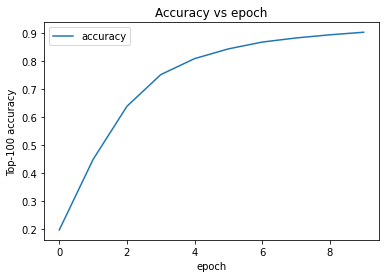

In [ ]:
# num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
import matplotlib.pyplot as plt
epochs = [i for i in range(10)]

plt.plot(epochs, model_hist.history["factorized_top_k/top_100_categorical_accuracy"], label="accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [ ]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(items.batch(10).map(model.item_model))

# Get recommendations.
j = str(40)
_, titles = index(tf.constant([j]))
print(f"Recommendations for user %s: {titles[0]}" %(j))

Recommendations for user 40: [143 412 158 298 410 292 114  10  74   0]


In [ ]:
tourism_id.loc[[143, 412, 158, 298, 410, 292, 114,  10,  74 ,  0]]["Place_Name"]

143                     Goa Jomblang
412    Museum TNI AL Loka Jala Crana
158                 Hutan Pinus Asri
298         Sendang Geulis Kahuripan
410        Masjid Muhammad Cheng Hoo
292                      Taman Badak
114                 Monumen Sanapati
10                    Pulau Bidadari
74                 SnowBay Waterpark
0                   Monumen Nasional
Name: Place_Name, dtype: object

In [ ]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(items.batch(10).map(model.item_model))

# Get recommendations.
j = str(1)
_, titles = index(tf.constant([j]))
print(f"Recommendations for user %s: {titles[0]}" %(j))

Recommendations for user 1: [ 18  24  28  23   6  20  17  11 364 381]


In [ ]:
tourism_id.loc[[ 18 , 24 , 28 , 23 ,  6 , 20 , 17 , 11, 364 ,381]]["Place_Name"]

18                      Kidzania
24             Pasar Tanah Abang
28     Wisata Kuliner Pecenongan
23               Museum Nasional
6         Kebun Binatang Ragunan
20                 Museum Wayang
17         Museum Bank Indonesia
11                    Pulau Pari
364             Waduk Jatibarang
381        Kampoeng Kopi Banaran
Name: Place_Name, dtype: object